## 1) Introduction

This simple notebook implements the mathematical forward models whose descriptions can be found [in this document](https://www.overleaf.com/project/623dc6078b3a6b1b29dfcc5a) (needs to be invited).

In [2]:
# The modules to import

from os import path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset

## 2) Input setup

Concerning the dimensions, like in the document we have :
* `N_i` the amount of pixels in a column;
* `N_j` the amount of pixels in a row;
* `N_ij` the product of `N_i` and `N_j`;
* `N_k` the amount of channels.

We retreive the input scene from a netCDF4 file and put it in the 3 dimensional matrix `Ux`, corresponding to the $U^{[x]}$ matrix in the document.

Then we instanciate the matrix `X`, which is `Ux` whose 2nd space dimension is flattened (corresponding to $X$).

Finally we get the `spectral_stencil`, the ordered array of the sampled wavelengths (in Ångström).

We define also a second pair of data, much smaller to be printed.

In [3]:
netCDF4_path = path.join("data", "multispectral_colorchecker.ns")

dataset = Dataset(netCDF4_path, 'r')
dataset.set_auto_mask(False)

# Declaration of Ux
Ux_1 = dataset.groups['radiance group'].variables['radiance matrix'][:, :, :].astype(float)
Ux_2 = np.zeros((10, 10, 3))

for i in range(10):
    for j in range(10):
        Ux_2[i, j] = [np.random.choice([0,1]), np.random.choice([0,1]), np.random.choice([0,1])]

# Declaration of the spectral stencil
spectral_stencil_1 = dataset.variables['spectral stencil'][:]
spectral_stencil_2 = np.array([4400, 5500, 6500])

# We decide which input to use
Ux = Ux_2
spectral_stencil = spectral_stencil_2

# Declaration of the dimensions
N_i, N_j, N_k = Ux.shape
N_ij = N_i * N_j

# Declaration of X
X = np.zeros((N_ij, N_k))

for k in range(N_k):
    X[:, k] = Ux[:, :, k].flatten('F')

## 3) Mask creation

In this part we declare `k_r`, `k_g` and `k_b`, the indices of the colors red, green and blue in the spectral stencil.

Then we construct the 3 dimensional matrices `UBayer` and `UQuad`. They are the implementation of the Bayer CFA and the Quad-Bayer CFA.

See $U^{[Bayer]}$ and $U^{[Quad]}$ in the document for more informations.

Like for `X`, we introduce `HBayer` and `HQuad`, the flatened versions of `UBayer` and `UQuad`.

We compute the two mask matrices with those expressions :

$$

\mathcal{U}^{[Bayer]}_{i, j, k} =
\left\{
\begin{array}{lll}
    1 & \text{if $k = k_r$ and} & \text{$i \bmod{2} = 0$ and $j \bmod{2} = 1$}\\
    1 & \text{if $k = k_g$ and} & \text{(($i \bmod{2} = 0$ and $j \bmod{2} = 0$) or}\\
    && \text{($i \bmod{2} = 1$ and $j \bmod{2} = 1$))}\\
    1 & \text{if $k = k_b$ and} & \text{$i \bmod{2} = 1$ and $j \bmod{2} = 0$}\\
    0 & \text{otherwise}
\end{array}
\right.

\text{and} \quad

\mathcal{U}^{[Quad]}_{i, j, k} =
\left\{
\begin{array}{lll}
    1 & \text{if $k = k_r$ and} & \text{$i \bmod{4} < 2$ and $j \bmod{4} \geq 2$}\\
    1 & \text{if $k = k_g$ and} & \text{(($i \bmod{4} < 2$ and $j \bmod{4} < 2$) or}\\
    && \text{($i \bmod{4} \geq 2$ and $j \bmod{4} \geq 2$))}\\
    1 & \text{if $k = k_b$ and} & \text{$i \bmod{4} \geq 2$ and $j \bmod{4} < 2$}\\
    0 & \text{otherwise}
\end{array}
\right.

$$

In [4]:
# Declaration of the indices of the wavelength of the red, green and blue colors
k_r = (np.abs(spectral_stencil - 6500)).argmin()
k_g = (np.abs(spectral_stencil - 5500)).argmin()
k_b = (np.abs(spectral_stencil - 4450)).argmin()

# Declaration of UBayer and UQuad
UBayer = np.zeros_like(Ux)
UQuad = np.zeros_like(Ux)

for i in range(N_i):
    for j in range(N_j):
        for k in range(N_k):
            if k == k_r:
                if i % 2 == 0 and j % 2 == 1:
                    UBayer[i, j, k] = 1

                if i % 4 < 2 and j % 4 >= 2:
                    UQuad[i, j, k] = 1

            elif k == k_g:
                if (i % 2 == 0 and j % 2 == 0) or (i % 2 == 1 and j % 2 == 1):
                    UBayer[i, j, k] = 1

                if (i % 4 < 2 and j % 4 < 2) or (i % 4 >= 2 and j % 4 >= 2):
                    UQuad[i, j, k] = 1

            elif k == k_b:
                if i % 2 == 1 and j % 2 == 0:
                    UBayer[i, j, k] = 1

                if i % 4 >= 2 and j % 4 < 2:
                    UQuad[i, j, k] = 1

# Declaration of the flattened mask matrices
HBayer = np.zeros((N_ij, N_k))
HQuad = np.zeros((N_ij, N_k))

for k in range(N_k):
    HBayer[:, k] = UBayer[:, :, k].flatten('F')
    HQuad[:, k] = UQuad[:, :, k].flatten('F')

## 4) Application of the masks

We use the formula :

$$
    y = \sum_{k = 1}^{N_k} X_{:k} \odot H_{:k}
$$

Where $y$ is a vector of $\mathbb{R}^{N_{ij}}$.

In [5]:
# Results of the masks
yBayer = sum(X[:, k] * HBayer[:, k] for k in range(N_k))
yQuad = sum(X[:, k] * HQuad[:, k] for k in range(N_k))

# Un-flatten the results
YBayer = np.reshape(yBayer, (N_i, N_j), order='F')
YQuad = np.reshape(yQuad, (N_i, N_j), order='F')

## 5) Binning matrix creation

In this part we define the matrix `B` to match the pattern of the Quad-Bayer CFA, except in the first $2 \times 2$ square where no binning is asked. This matrix will guide the computations during the binning (see the matrix $B$ in the document).

In [6]:
# Construcion of the matrix B
B = np.zeros((N_i, N_j))

for i in range(N_i):
    for j in range(N_j):
        if i % 2 == 0 and j % 2 == 0:
            B[i, j] = 2

B[:2, :2] = np.ones((2, 2))

## 6) Performing the binning

The operation is done by filling the output $Y^{bin}$ aggregated squares by aggregated squares.

We use the formula stating that $\forall (i, j) \in \{0, ..., N_{i} - 1\} \times \{0, ..., N_{j} - 1\}$ such that $B_{i, j} = l \ne 0$ we have :

$$
    Y^{bin}_{i:i + l - 1, j:j + l - 1} = \mathcal{A}(Y, i, j, l)
$$

In [7]:
# Result of the binning
Ybin = np.zeros((N_i, N_j))

for i in range(N_i):
    for j in range(N_j):
        l = int(B[i, j])
        if l != 0:
            mean_value = np.mean(YQuad[i:i + l, j:j + l])

            for ii in range(l):
                for jj in range(l):
                    Ybin[i + ii, j + jj] = mean_value

## 7) Visualization

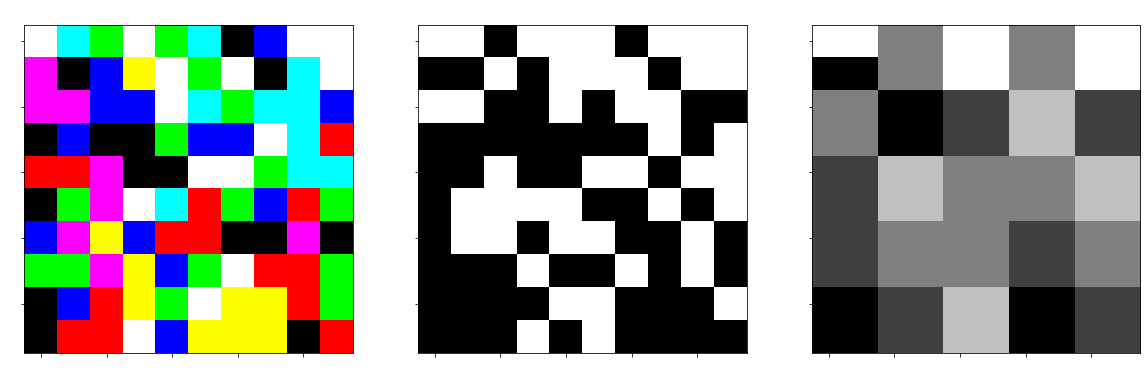

In [8]:
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.imshow(Ux)
plt.title("The input image Ux", color="white", fontsize=16)
plt.xticks(color="white", fontsize=16)
plt.yticks(color="white", fontsize=16)

plt.subplot(1, 3, 2)
plt.imshow(YQuad, cmap='gray')
plt.title("The result from the Quad-Bayer CFA", color="white", fontsize=16)
plt.xticks(color="white", fontsize=16)
plt.yticks(color="white", fontsize=16)

plt.subplot(1, 3, 3)
plt.imshow(Ybin, cmap='gray')
plt.title("The binned result", color="white", fontsize=16)
plt.xticks(color="white", fontsize=16)
plt.yticks(color="white", fontsize=16)
plt.show()